# main
- TODO: Something to do with local high. Filter so that only count if current rally's high is the highest for past 7 days or something

In [1]:
from binance.client import Client
from downloader import Downloader
import matplotlib.pyplot as plt
dl = Downloader()
import pandas as pd
import time
from datetime import datetime
import numpy as np
import statsmodels.formula.api as sm
import math
import seaborn as sns


In [2]:
import metalabeller as ml
import ta

In [51]:
df = dl.get_working_data("ATOMUSDT")
# df = dl.get_working_data("DOTUSDT")
# df = dl.get_working_data("DOGEUSDT")
# df = dl.get_working_data("ADAUSDT")
# df = dl.get_working_data("BATUSDT")
# df = dl.get_working_data("SOLUSDT")

In [52]:
df["macd"] = ta.macd(df.close, result="hist")
df["macd_past"] = df.macd.shift(1)
df["ema"] = df.close.ewm(span=500).mean()
df["ema_diff"] = df.ema.diff()
df.dropna(inplace=True)
t0 = df[(df.macd<0) & (df.macd_past>0)].index
tn1 = df[(df.macd>0) & (df.macd_past<0)].index

In [53]:
def get_base_macd_events(df, tn1, t0, mlen=3, stdev=2):
    """
    returns all macd events satisfying criteria:
    - length > mlen
    - gain is at least stdev standard deviations
    """
    stats = ["tn1", "t0", "gain", "length"]
    result = pd.DataFrame(np.nan, index=range(len(t0)), columns=stats)
    ls = tn1.searchsorted(t0, side='left', sorter=None)-1   # location of start (corresponding
                                                            # tn1 for t0
    for i in range(len(t0)):
        if ls[i]<0: continue 
        if tn1[ls[i]]-pd.Timedelta(days=7) not in df.index: continue
        df_ = df.loc[tn1[ls[i]]:t0[i]]
        if df_.shape[0]<mlen: continue
        
        row = dict.fromkeys(stats, 0.)
        row["tn1"] = tn1[ls[i]]
        row["t0"] = t0[i]
        row["gain"] = (max(df_.high)-df_.iloc[0].close)/df_.iloc[0].close
        row["length"] = len(df_)
        result.iloc[i] = row
    
    min_gain = np.mean(result.gain)+stdev*np.std(result.gain)
    result = result[result.gain > min_gain]
    result.dropna(inplace=True)
    result.index = range(len(result))
    return result

In [54]:
import time

In [55]:
t = time.time()
result_ = get_base_macd_events(df, tn1, t0, mlen=3, stdev=2)
time.time()-t

16.67859387397766

In [56]:
result_

,tn1,t0,gain,length
0,2019-05-09 21:00:00,2019-05-10 01:15:00,0.136778,18.0
1,2019-05-15 16:45:00,2019-05-15 18:15:00,0.079622,7.0
2,2019-05-17 08:00:00,2019-05-17 10:00:00,0.086129,9.0
3,2019-05-18 01:15:00,2019-05-18 04:15:00,0.065954,13.0
4,2019-05-18 13:45:00,2019-05-18 16:30:00,0.074114,12.0
...,...,...,...,...
222,2021-09-26 09:00:00,2021-09-26 11:30:00,0.078689,11.0
223,2021-09-26 14:45:00,2021-09-26 17:00:00,0.071153,10.0
224,2021-10-12 13:00:00,2021-10-12 16:15:00,0.120718,14.0
225,2021-10-13 19:30:00,2021-10-13 22:45:00,0.068902,14.0


In [57]:
def get_macd_events(df, events, min_length=3):
    """
    returns macd events, starting at tn1 when macd crosses signal to the upside, 
    and t0 when macd crosses back down the signal. 
    df has columns [open, high, low, close, volume]
    tn1 and t0 are DatetimeIndex.
    min_length is how short a trend leg can be, in bars amount. Must be at least 3
    
    returns dataframe of events with columns
    - vdiff7: mean of volume of impulse buy divided by mean volume of last 7 days
    - vdiff30: mean of volume of impulse buy divided by mean volume of last 30 days
    - vmax: max volume hour divided by all volume in impulse buy 
    - length: number of hours of inpulse buy 
    - end: (close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback
    - h1: mean height of bars for first 1/3 of leg / mean height of bars for entire leg
    - h2: mean height of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - h3: mean height of bars for 2/3 of leg to end / mean height of bars for entire leg
    - hr7: mean heights of trend leg bars over mean heights of bars for past 7 days 
    - hr30: mean heights of trend leg bars over mean heights of bars for past 30 days 
    - v0: volume for trend leg before climax / total volume of trend leg
    - v1: volume for trend leg after climax / total volume of trend leg
    - cr: close relative: mean of all bars (close-low)/(high-low)
    - cr7: close relative over close relative for past 7 days
    - cr30: close relative over close relative over past 30 days
    - cr1: mean close of bars for first 1/3 of leg / mean height of bars for entire leg
    - cr2: mean close of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - cr3: mean close of bars for 2/3 of leg to end / mean height of bars for entire leg
    """
    stats = ["gain", "vdiff7", "vdiff30", "vmax", "length", "end", "h1", "h2", "h3", "hr7", "hr30", 
             "v0", "v1", "cr", "cr7", "cr30", "cr1", "cr2", "cr3", 
             "macd", "macd_avg", "md1", "md7", "dm1", "dm7", "trend"]
    result = pd.DataFrame(np.nan, index=events.t0, columns=stats)

    for i in range(len(events)):
        if events.tn1[i]-pd.Timedelta(days=7) not in df.index: continue
        df_ = df.loc[events.tn1[i]:events.t0[i]]
        df_1 = df.loc[events.tn1[i]-pd.Timedelta(days=1):events.t0[i]]
        df_7 = df.loc[events.tn1[i]-pd.Timedelta(days=7):events.t0[i]]
        if df_.shape[0]<min_length: continue
        row = dict.fromkeys(stats, 0.)
        row["gain"] = events.gain[i]
        row["vdiff7"] = (sum(df_.volume)/df_.shape[0])/(sum(df_1.volume)/df_1.shape[0])
        row["vdiff30"] = (sum(df_.volume)/df_.shape[0])/(sum(df_7.volume)/df_7.shape[0])
        row["vmax"] = get_max_vol_in_leg(df_)
        row["length"] = len(df_)
        row["end"] = get_pct_pullback(df_)
        row["h1"], row["h2"], row["h3"] = get_heights(df_)
        row["hr7"] = get_height(df_)/get_height(df_1)
        row["hr30"] = get_height(df_)/get_height(df_7)
        row["v0"], row["v1"] = get_volume_before_after(df_)
        row["cr"] = get_close_relative(df_)
        row["cr7"] = row["cr"]/get_close_relative(df_1)
        row["cr30"] = row["cr"]/get_close_relative(df_7)
        row["cr1"], row["cr2"], row["cr3"] = get_triple_close_relative(df_)
        row["macd"] = max(df_.macd)/df_.iloc[0].close
        row["macd_avg"] = sum(df_.macd)/(df_.iloc[0].close*df_.shape[0])
        row["md1"] = max(df_.macd)/max(df_1.macd) #momentum divergence, 1 is none, 0.5 is half 
        row["md7"] = max(df_.macd)/max(df_7.macd)
        row["dm1"] = -min(df_1.macd)/max(df_.macd) #downward momentum
        row["dm7"] = -min(df_7.macd)/max(df_.macd)
        row["trend"] = sum(df_7.ema_diff)/(df_7.shape[0]*df_.iloc[0].close)

        result.iloc[i] = row
    return result.dropna()
        
        

    

In [58]:
def get_max_vol_in_leg(df):
    """returns max volume hour divided by all volume in impulse buy """
    v = max(df.volume)
    return v/sum(df.volume)

def get_pct_pullback(df):
    """(close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback"""
    return (df.iloc[-1].close-df.iloc[0].low)/(max(df.high)-df.iloc[0].low)

def get_heights(df):
    """returns ranges of the bars, over mean of all bars in the impulse buy"""
    a = int(round(df.shape[0]/3, 0))
    b = int(round(df.shape[0]*2/3, 0))
    t = get_height(df)
    return get_height(df.iloc[:a])/t, get_height(df.iloc[a:b])/t, get_height(df.iloc[b:])/t
    
def get_height(df):
    return sum(map(lambda h,l: h-l, df.high, df.low))/df.shape[0]

def get_volume_before_after(df):
    ind = list(df.high).index(max(df.high))+1
    vol = sum(df.volume)
    return sum(df.iloc[:ind].volume)/vol, sum(df.iloc[ind:].volume)/vol

def get_close_relative(df):
    """returns the mean close relative to bar for entire df. 
    Closing halfway between high and low returns 0.5"""
#     def cr(h,l,c):
#         return (c-l)/(h-l) if (h-l!= 0) else 0
    return sum(map(lambda h, l, c: (c-l)/(h-l) if (h-l!= 0) else 0, df.high, df.low, df.close))/df.shape[0]

def get_triple_close_relative(df):
    """
    returns close relative for third segments of df over total
    """
    t = get_close_relative(df)
    a = int(round(df.shape[0]/3, 0))
    b = int(round(df.shape[0]*2/3, 0))
    return get_close_relative(df.iloc[:a])/t, get_close_relative(df.iloc[a:b])/t, get_close_relative(df.iloc[b:])/t

In [59]:
events_ = get_macd_events(df, result_, min_length=3)

In [60]:
events_

,gain,vdiff7,vdiff30,vmax,length,end,h1,h2,h3,hr7,...,cr1,cr2,cr3,macd,macd_avg,md1,md7,dm1,dm7,trend
t0,,,,,,,,,,,,,,,,,,,,,
2019-05-10 01:15:00,0.136778,1.812513,1.757097,0.171494,18.0,0.621795,1.128729,0.798895,1.072376,1.477424,...,0.981927,1.180108,0.837964,0.041677,0.017145,1.000000,0.801936,0.550678,0.910868,0.000084
2019-05-15 18:15:00,0.079622,2.813856,4.596902,0.234054,7.0,0.432150,0.722465,1.325796,0.788840,2.797959,...,1.221217,1.119131,0.600087,0.034673,0.016710,1.000000,1.000000,0.235533,0.707449,-0.000244
2019-05-17 10:00:00,0.086129,3.489827,5.433338,0.198681,9.0,0.642994,1.194673,0.880786,0.924540,1.960189,...,1.158527,0.976147,0.865326,0.046057,0.023168,1.000000,1.000000,0.700004,1.000595,-0.000077
2019-05-18 04:15:00,0.065954,0.783547,1.303527,0.133638,13.0,0.549839,0.830268,1.310338,0.781809,0.765489,...,1.330656,1.147059,0.485520,0.017951,0.009094,0.388423,0.388423,2.537877,2.576044,0.000002
2019-05-18 16:30:00,0.074114,2.877246,3.326267,0.164795,12.0,0.724670,0.914894,1.051064,1.034043,1.469090,...,1.077510,0.982551,0.939939,0.022698,0.012605,1.000000,0.519972,0.814342,1.924325,0.000045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-26 11:30:00,0.078689,1.694282,0.946581,0.216428,11.0,0.614094,1.376866,0.955224,0.656716,1.169876,...,1.261032,0.973157,0.759101,0.041769,0.017957,1.000000,0.731386,0.480090,1.096348,0.000140
2021-09-26 17:00:00,0.071153,1.675125,0.959151,0.176634,10.0,0.736156,1.057304,1.038136,0.891848,1.414475,...,1.246875,1.156801,0.544057,0.030652,0.013501,0.780553,0.570886,0.615064,1.404578,0.000122
2021-10-12 16:15:00,0.120718,2.922563,3.198803,0.178906,14.0,0.846336,0.941717,0.775449,1.237924,1.897074,...,1.268752,1.046054,0.694405,0.032602,0.016613,1.000000,1.000000,0.492265,0.682324,-0.000183


In [61]:
events = events_[events_.trend>0]

In [62]:
events

,gain,vdiff7,vdiff30,vmax,length,end,h1,h2,h3,hr7,...,cr1,cr2,cr3,macd,macd_avg,md1,md7,dm1,dm7,trend
t0,,,,,,,,,,,,,,,,,,,,,
2019-05-10 01:15:00,0.136778,1.812513,1.757097,0.171494,18.0,0.621795,1.128729,0.798895,1.072376,1.477424,...,0.981927,1.180108,0.837964,0.041677,0.017145,1.000000,0.801936,0.550678,0.910868,0.000084
2019-05-18 04:15:00,0.065954,0.783547,1.303527,0.133638,13.0,0.549839,0.830268,1.310338,0.781809,0.765489,...,1.330656,1.147059,0.485520,0.017951,0.009094,0.388423,0.388423,2.537877,2.576044,0.000002
2019-05-18 16:30:00,0.074114,2.877246,3.326267,0.164795,12.0,0.724670,0.914894,1.051064,1.034043,1.469090,...,1.077510,0.982551,0.939939,0.022698,0.012605,1.000000,0.519972,0.814342,1.924325,0.000045
2019-05-24 15:30:00,0.083352,2.863823,2.623674,0.247701,14.0,0.662371,0.429767,0.355426,2.085891,1.919279,...,0.933657,1.179916,0.922410,0.018662,0.010729,0.962141,0.592302,0.975762,1.513919,0.000094
2019-05-30 05:00:00,0.127238,4.828090,5.467594,0.249580,12.0,0.725118,0.630728,1.237197,1.132075,2.798826,...,1.153982,1.099004,0.747014,0.038625,0.020173,1.000000,1.000000,0.299011,0.774401,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-22 17:15:00,0.121726,0.974603,1.112839,0.129012,20.0,0.767281,0.868074,0.985246,1.144572,0.961378,...,0.910179,1.303284,0.829863,0.023212,0.013240,0.563118,0.360361,1.350297,1.648928,0.000160
2021-09-24 15:30:00,0.093601,1.565159,1.584503,0.102736,17.0,0.507692,0.882460,1.321244,0.849837,1.399169,...,1.107108,1.319214,0.626880,0.050460,0.021769,1.000000,0.913017,0.878246,0.878246,0.000177
2021-09-24 23:00:00,0.118969,1.027791,0.970552,0.158095,19.0,0.730994,0.798424,1.074665,1.114467,1.080168,...,0.948407,1.146262,0.880953,0.024653,0.011317,0.511424,0.466939,1.717256,1.717256,0.000177


In [19]:
a = df.to_numpy()

In [28]:
ma = df.open.rolling(window=10000).mean().diff()

In [107]:
def find_pivots(df, unit = 1000):
    """returns timestamps of peaks"""
    i = 0
    price = df.open.to_list()
    timestamps = df.timestamp.to_list()
    h_ts = [] #high timestamps
    l_ts = []
    past = price[0]
    now = price[0]
    future = price[unit]
    while True:
        if now>past and now>future:
            h_ts.append(timestamps[i])
        elif now<past and now<future:
            l_ts.append(timestamps[i])
        i += unit
        past = now
        now = future
        try:
            future = price[i+unit]
        except:
            break
    return h_ts, l_ts
                

In [112]:
h, l = find_pivots(df)

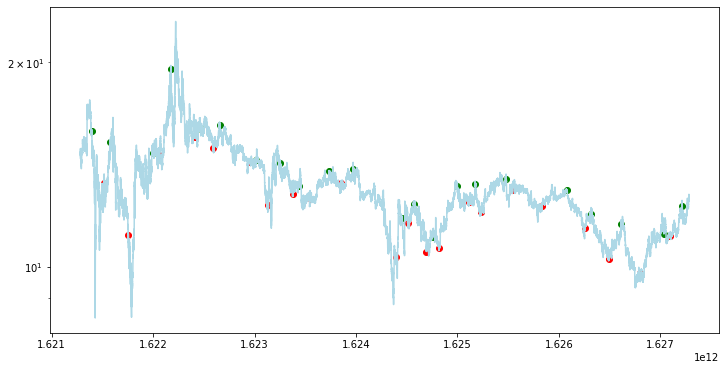

In [113]:

fig, ax = plt.subplots(figsize=(12, 6))
plotdf = df[-200000:-100000]
h = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, h))
l = list(filter(lambda x: x>plotdf.iloc[0].timestamp and x<plotdf.iloc[-1].timestamp, l))

plt.yscale("log")
ax.plot(plotdf.set_index("timestamp").open, c="lightblue")
ax.scatter(h, plotdf.set_index("timestamp").reindex(h)["open"], c="green")
ax.scatter(l, plotdf.set_index("timestamp").reindex(l)["open"], c="red")

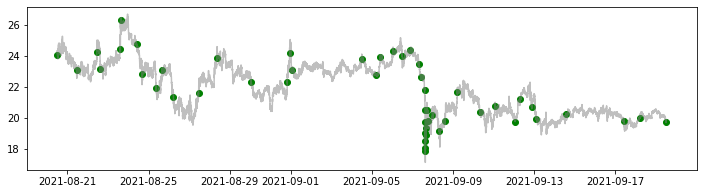

In [8]:
t_range = t_events[-100:-50]
fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(t_range, df.reindex(t_range).open, c="green")
ax.plot(df[(df.index>t_range[0]) & (df.index<t_range[-1])].open, c="gray", alpha=0.5)

In [63]:
t_events = events.index

In [64]:
# vol = ml.get_daily_vol(df.close)
# t_events = ml.get_t_events(df.close, vol, 0.02)
t1 = ml.get_vertical_barrier(df.close, t_events, 3)

verify that get_vertical_barrier works as expected, use above code
remove above remove duplicates code with BTC data and see if it works


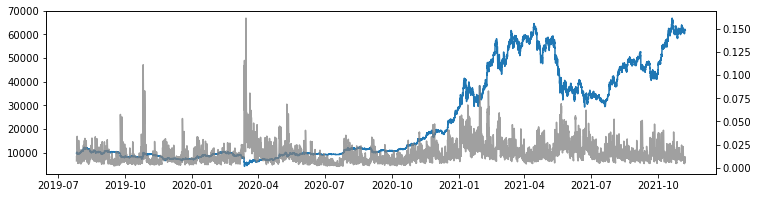

In [327]:
a = [-20000, -1]
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(df.open[a[0]:a[1]])
ax1 = ax.twinx()
ax1.plot(vol[a[0]:a[1]], c="gray", alpha=0.75)

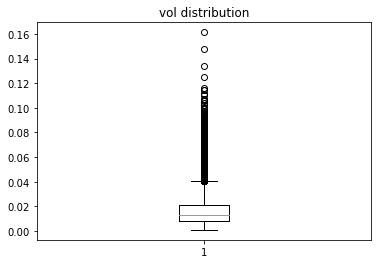

In [328]:
fig, ax = plt.subplots()
ax.set_title('vol distribution')
ax.boxplot(list(vol.dropna()))
plt.show()

In [65]:
# side = pd.Series(np.random.randint(0, 2, len(t_events)), index=t_events)

In [66]:
# # create target series
# ptsl = [1,1]
# min_ret = 0.00
    
# # events = ml.get_events(df.open,t_events,ptsl,vol,min_ret,1,t1=t1,side=side)
# events = ml.get_events(df.open,t_events,ptsl,vol,min_ret,1,t1=t1,side=pd.Series(1.,index=t_events))

# events

In [74]:
pd.options.mode.chained_assignment = None
events["t1"] = t1
events["trgt"] = events.gain

In [75]:
# labels = ml.get_bins(events, df.close, t1)

In [76]:
def get_bins(events, df):
    """generates labels with t0 index, return, and target"""
    out = pd.DataFrame(index=events.index, columns=["ret", "target"])
    for t in events.index:
        event = events.loc[t]
        df_ = df.loc[t:event.t1]
        tp_price = event.trgt*df_.iloc[0].close+df_.iloc[0].close
        sl_price = -event.trgt*df_.iloc[0].close+df_.iloc[0].close
        tp = df_[df_.high>tp_price].index
        sl = df_[df_.low<sl_price].index
#         return out, t, {"ret":(df_.iloc[-1].close-df_.iloc[0].close)/df_.iloc[0].close, "target":0}
        if len(tp)==0 and len(sl)==0: 
            out.loc[t] = {"ret":(df_.iloc[-1].close-df_.iloc[0].close)/df_.iloc[0].close, "target":0}
        elif len(tp)==0: 
            out.loc[t] = {"ret":-event.trgt, "target":0}
        elif len(sl)==0: 
            out.loc[t] = {"ret":event.trgt, "target":1}
        else: 
            out.loc[t] = {"ret":event.trgt if tp[0]<sl[0] else -event.trgt, 
                           "target": 1 if tp[0]<sl[0] else 0}
    return out

In [77]:
labels = get_bins(events, df)

In [78]:
labels

,ret,target
t0,,
2019-05-10 01:15:00,-0.012378,0.0
2019-05-18 04:15:00,0.065954,1.0
2019-05-18 16:30:00,-0.074114,0.0
2019-05-24 15:30:00,-0.083352,0.0
2019-05-30 05:00:00,0.127238,1.0
...,...,...
2021-09-22 17:15:00,0.121726,1.0
2021-09-24 15:30:00,0.093601,1.0
2021-09-24 23:00:00,-0.118969,0.0


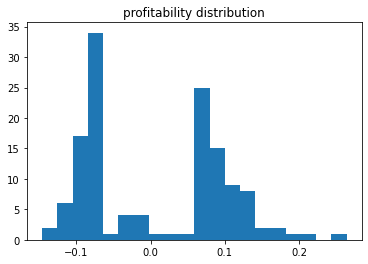

In [79]:
fig, ax = plt.subplots()
ax.set_title('profitability distribution')
ax.hist(labels.ret, bins=20)
plt.show()

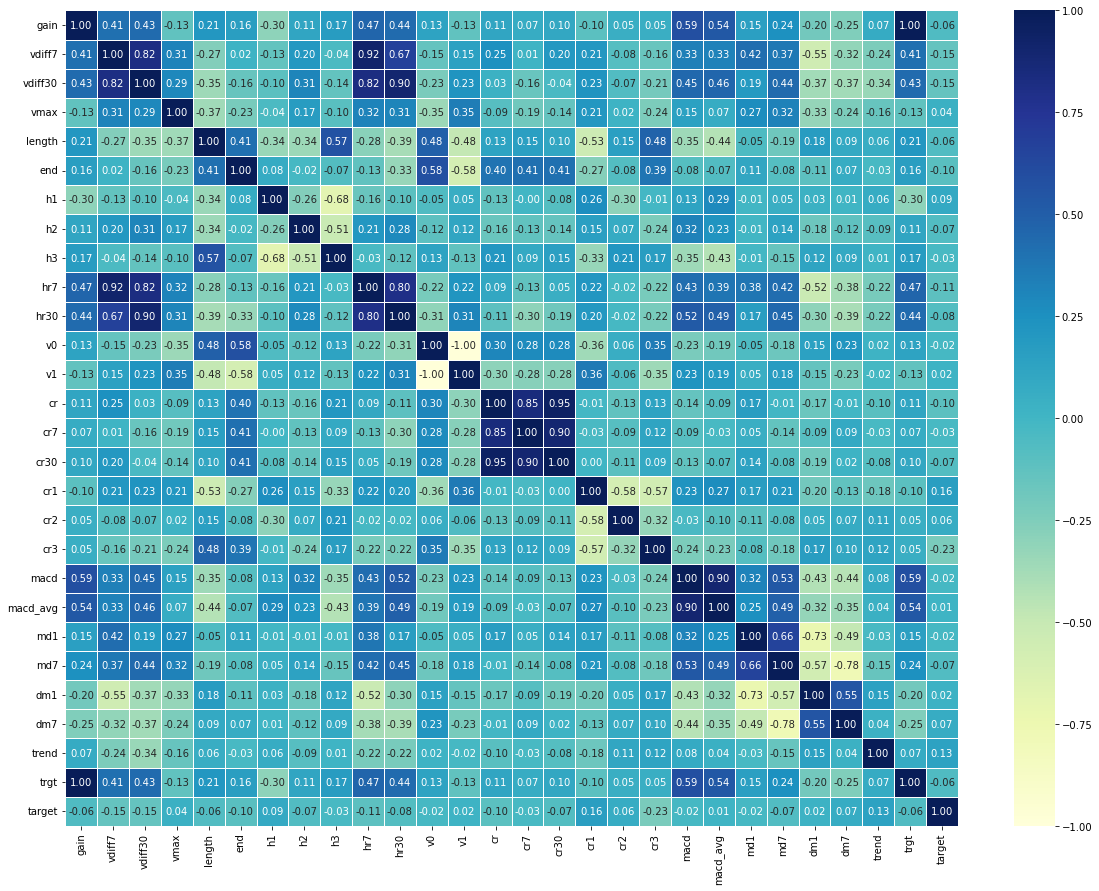

In [80]:
indicators = list(events.columns)
indicators.append("target")

# d = df[list(indicators)].copy()
d = events.copy()
d["target"] = list(labels.target)
corr_matrix = d.corr()
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".2f",
                 cmap="YlGnBu")

    - vdiff7: mean of volume of impulse buy divided by mean volume of last 7 days
    - vdiff30: mean of volume of impulse buy divided by mean volume of last 30 days
    - vmax: max volume hour divided by all volume in impulse buy 
    - length: number of hours of inpulse buy 
    - end: (close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback
    - h1: mean height of bars for first 1/3 of leg / mean height of bars for entire leg
    - h2: mean height of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - h3: mean height of bars for 2/3 of leg to end / mean height of bars for entire leg
    - hr7: mean heights of trend leg bars over mean heights of bars for past 7 days 
    - hr30: mean heights of trend leg bars over mean heights of bars for past 30 days 
    - v0: volume for trend leg before climax / total volume of trend leg
    - v1: volume for trend leg after climax / total volume of trend leg
    - cr: close relative: mean of all bars (close-low)/(high-low)
    - cr7: close relative over close relative for past 7 days
    - cr30: close relative over close relative over past 30 days
    - cr1: mean close of bars for first 1/3 of leg / mean height of bars for entire leg
    - cr2: mean close of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - cr3: mean close of bars for 2/3 of leg to end / mean height of bars for entire leg

In [86]:
i = -1

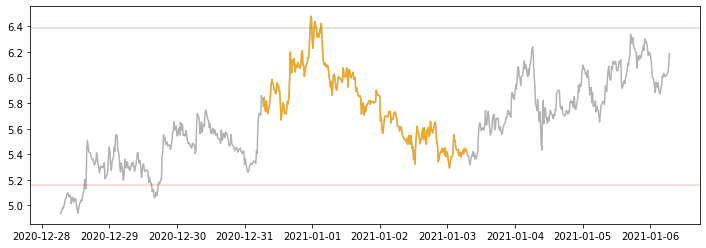

In [133]:
i+=1
item = events.index[i]
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df.loc[item-pd.Timedelta(days=3):t1[item]+pd.Timedelta(days=3)].close, c="black", alpha=0.3)
ax.plot(df.loc[item:events.loc[item].t1].close, c="orange", alpha=0.8)
ax.axhline(df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="green", alpha=0.2)
ax.axhline(-df.loc[item].close*events.loc[item].trgt+df.loc[item].close, c="red", alpha=0.2)


In [31]:
item

Timestamp('2017-09-29 19:00:00')

In [33]:
t1

timestamp
2017-09-18 15:00:00   2017-09-20 15:00:00
2017-09-29 19:00:00   2017-10-01 19:00:00
2017-10-09 23:00:00   2017-10-11 23:00:00
2017-10-12 17:00:00   2017-10-14 17:00:00
2017-10-13 07:00:00   2017-10-15 07:00:00
                              ...        
2021-10-15 09:00:00   2021-10-17 09:00:00
2021-10-15 22:00:00   2021-10-17 22:00:00
2021-10-20 20:00:00   2021-10-22 20:00:00
2021-11-01 14:00:00   2021-11-03 14:00:00
2021-11-04 02:00:00   2021-11-06 02:00:00
Name: timestamp, Length: 408, dtype: datetime64[ns]

In [14]:
lookback = 4000
def get_z_score(a, b):
    """Returns the latest zscore between dataframes a and b. IF NAN, RETURN PREVIOUS"""
    a = a.set_index("timestamp") #Do not set inplace cause reference
    b = b.set_index("timestamp")

    df = pd.to_numeric(a.open.rename("A")).to_frame()
    df["B"] = pd.to_numeric(b.open)

    df.dropna(inplace=True)

    results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
    hr = results.params[1]
    spread = pd.Series((df['B'] - hr * df['A'])).rename("spread").to_frame()
    spread["mean"] = spread.spread.rolling(lookback).mean()
    spread["std"] = spread.spread.rolling(lookback).std()
    spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])
    return get_non_nan_zscore(spread)    
    
def get_non_nan_zscore(spread):
    """loops through spread finding latest non-nan zscore"""
    zscore = spread.iloc[-1].zscore
    i = 2
    while math.isnan(zscore):
        zscore = spread.iloc[-i].zscore
        i += 1
    return zscore

In [10]:
a = dl.get_minutely_data("HNTUSDT", past=False)
b = dl.get_minutely_data("BTCUSDT", past=False)

In [17]:
z = get_z_score(a, b)

In [18]:
z

-0.15050287861225423

In [ ]:
def get_macd_events(df, tn1, t0, min_length=3):
    """
    returns macd events, starting at tn1 when macd crosses signal to the upside, 
    and t0 when macd crosses back down the signal. 
    df has columns [open, high, low, close, volume]
    tn1 and t0 are DatetimeIndex.
    min_length is how short a trend leg can be, in bars amount. Must be at least 3
    
    returns dataframe of events with columns
    - vdiff7: mean of volume of impulse buy divided by mean volume of last 7 days
    - vdiff30: mean of volume of impulse buy divided by mean volume of last 30 days
    - vmax: max volume hour divided by all volume in impulse buy 
    - length: number of hours of inpulse buy 
    - end: (close-low)/(high-low), where low refers to low of first hour, high is highest inpulse buy,
            close if closing price of last bar of inpulse buy. Indicates % pullback
    - h1: mean height of bars for first 1/3 of leg / mean height of bars for entire leg
    - h2: mean height of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - h3: mean height of bars for 2/3 of leg to end / mean height of bars for entire leg
    - hr7: mean heights of trend leg bars over mean heights of bars for past 7 days 
    - hr30: mean heights of trend leg bars over mean heights of bars for past 30 days 
    - v0: volume for trend leg before climax / total volume of trend leg
    - v1: volume for trend leg after climax / total volume of trend leg
    - cr: close relative: mean of all bars (close-low)/(high-low)
    - cr7: close relative over close relative for past 7 days
    - cr30: close relative over close relative over past 30 days
    - cr1: mean close of bars for first 1/3 of leg / mean height of bars for entire leg
    - cr2: mean close of bars for 1/3-2/3 of leg / mean height of bars for entire leg
    - cr3: mean close of bars for 2/3 of leg to end / mean height of bars for entire leg
    """
    stats = ["vdiff7", "vdiff30", "vmax", "length", "end", "h1", "h2", "h3", "hr7", "hr30", 
             "v0", "v1", "cr", "cr7", "cr30", "cr1", "cr2", "cr3", 
             "macd", "macd_avg", "macd_neg", "macd_neg_avg", "trend"]
    result = pd.DataFrame(np.nan, index=t0, columns=stats)
    ls = tn1.searchsorted(t0, side='left', sorter=None)-1   # location of start (corresponding
                                                            # tn1 for t0
    for i in range(len(t0)):
        if ls[i]<0: continue 
        if tn1[ls[i]]-pd.Timedelta(days=7) not in df.index: continue
        df_ = df.loc[tn1[ls[i]]:t0[i]]
        df_1 = df.loc[tn1[ls[i]]-pd.Timedelta(days=1):t0[i]]
        df_7 = df.loc[tn1[ls[i]]-pd.Timedelta(days=7):t0[i]]
        df_neg = df.loc[t0[i-1]:tn1[ls[i]]]     #Negative macd, before start
        if df_.shape[0]<min_length: continue
        row = dict.fromkeys(stats, 0.)
        
        row["vdiff7"] = (sum(df_.volume)/df_.shape[0])/(sum(df_1.volume)/df_1.shape[0])
        row["vdiff30"] = (sum(df_.volume)/df_.shape[0])/(sum(df_7.volume)/df_7.shape[0])
        row["vmax"] = get_max_vol_in_leg(df_)
        row["length"] = len(df_)
        row["end"] = get_pct_pullback(df_)
        row["h1"], row["h2"], row["h3"] = get_heights(df_)
        row["hr7"] = get_height(df_)/get_height(df_1)
        row["hr30"] = get_height(df_)/get_height(df_7)
        row["v0"], row["v1"] = get_volume_before_after(df_)
        row["cr"] = get_close_relative(df_)
        row["cr7"] = row["cr"]/get_close_relative(df_1)
        row["cr30"] = row["cr"]/get_close_relative(df_7)
        row["cr1"], row["cr2"], row["cr3"] = get_triple_close_relative(df_)
        row["macd"] = max(df_.macd)/df_.iloc[-1].close
        row["macd_avg"] = sum(df_.macd)/(df_.iloc[-1].close*df_.shape[0])
        row["macd_neg"] = min(df_neg.macd)/df_.iloc[-1].close
        row["macd_neg_avg"] = sum(df_neg.macd)/(df_.iloc[-1].close*df_.shape[0])
        row["trend"] = sum(df_7.ema_diff)/df_7.shape[0]

        result.iloc[i] = row
    return result.dropna()
        
        

    